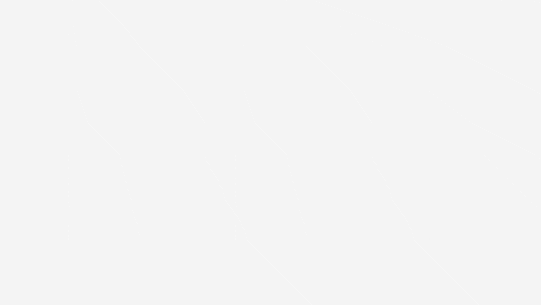

# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

This analysis loosely follows the [paper for the discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0040) (mostly Section 5 and 5.1).

For the sort of level of understanding required to follow this notebook, you can read this [article on the Higgs boson](http://hyperphysics.phy-astr.gsu.edu/hbase/Forces/higgs.html?fbclid=IwAR1ocxfiTOUW2dsdn1AMUL8IBnyBARS8mKKpWIlosTor66yRBdyyHH12naA#c1).

By the end of this notebook you will be able to:
1. rediscover the Higgs boson yourself!
2. know some general principles of a particle physics analysis

The datasets used in this notebook have already been filtered to include at least 2 photons per event, so that processing is quicker.

All Feynman diagram pictures are borrowed from our friends at [Particle Zoo](https://www.particlezoo.net).

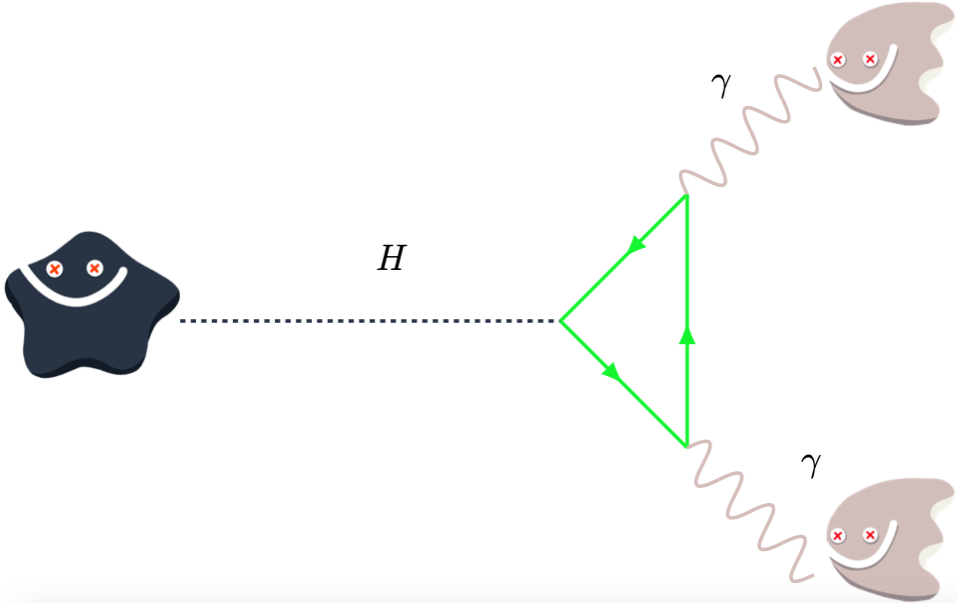

## Running a Jupyter notebook <a id="running"></a>

To run the whole Jupyter notebook, in the top menu click Run -> Run all.

To propagate a change you've made to a piece of code, click Run -> Run after.

You can also run a single code cell, by using the keyboard shortcut Shift+Enter.
    

## Setting up <a id="setting_up"></a>

(To be done every time you re-open this notebook)

We're going to be using a number of tools to help us:
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* scipy: tool for statistical fitting

In [ ]:
import pandas as pd # to store data as dataframe
import numpy as np # # for numerical calculations such as histogramming
from scipy.optimize import curve_fit # for the signal and background fit

## Input data <a id="fraction"></a>

Samples to process, fraction of data used, and sample cycling function.

In [ ]:
samples_list = ['data_A'] # add 'data_B','data_C','data_D' later if you want

fraction = 0.8 # increase this later if you want

DataFrames = {} # define empty dictionary to hold dataframes
for s in samples_list: # loop over samples
    DataFrames[s] = pd.read_csv('/kaggle/input/gamgam-csv/'+s+'.csv', index_col='entry') # read .csv file
all_data = pd.concat(DataFrames) # merge DataFrames into one

## Invariant mass calculation

(**Tip!!** Momentum is a vector quantity, so use your mathematical vector knowledge to find its magnitude.)

The invariant mass *M* of a parent particle decaying to two daughter particles is related to properties of the daughter particles by the formula:

$$M^2=E^2-p^2,$$

where *E* is the total energy of the daughter particles, and *p* is the magnitude of the vector sum of the momenta of the daughter particles.

In [ ]:
def calc_myy(photon_pt_1,photon_eta_1,photon_phi_1,photon_E_1,
             photon_pt_2,photon_eta_2,photon_phi_2,photon_E_2):
    # 1st photon is _1, 2nd photon is _2 etc
    
    sumE = photon_E_1 + photon_E_2 # sumE = sum of energy
    px_1 = photon_pt_1*np.cos(photon_phi_1) # x-momentum of photon_1
    px_2 = photon_pt_2*np.cos(photon_phi_2) # x-momentum of photon_2
    py_1 = photon_pt_1*np.sin(photon_phi_1) # y-momentum of photon_1
    py_2 = photon_pt_2*np.sin(photon_phi_2) # y-momentum of photon_2
    pz_1 = photon_pt_1*np.sinh(photon_eta_1) # z-momentum of photon_1
    pz_2 = photon_pt_2*np.sinh(photon_eta_2) # z-momentum of photon_2
    sumpx = px_1 + px_2 # sumpx = sum of x-momenta 
    sumpy = py_1 + py_2 # sumpy = sum of y-momenta 
    sumpz = pz_1 + pz_2 # sumpz = sum of z-momenta
    sump = np.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # sump = magnitude of total momentum
    myy = np.sqrt(sumE**2 - sump**2) # myy = invariant mass from M^2 = E^2 - p^2
    
    return myy

Then myy is calculated for each row in the data

In [ ]:
# myy is calculated for each row in the data
all_data['myy'] = np.vectorize(calc_myy)(all_data['photon_pt_1'],
                                         all_data['photon_eta_1'],
                                         all_data['photon_phi_1'],
                                         all_data['photon_E_1'],
                                         all_data['photon_pt_2'],
                                         all_data['photon_eta_2'],
                                         all_data['photon_phi_2'],
                                         all_data['photon_E_2'])

In [ ]:
# Select eta outside the barrel/end-cap transition region
# you can think of eta as the photon's position in the detector
# paper: "excluding the calorimeter barrel/end-cap transition region 1.37 < |η| < 1.52"
def select_eta(photon_eta_1,photon_eta_2):
# want to keep events where absolute value of photon_eta is outside the range 1.37 to 1.52
    # if absolute value of either photon_eta between 1.37 and 1.52: return False
    if abs(photon_eta_1)>1.37 and abs(photon_eta_1)<1.52: return False
    if abs(photon_eta_2)>1.37 and abs(photon_eta_2)<1.52: return False
    else: return True
    
all_data = all_data[ np.vectorize(select_eta)(all_data.photon_eta_1,all_data.photon_eta_2) ]


# Select photons with high pt
# pt is related to the photon's momentum
# paper: "The leading (sub-leading) photon candidate is required to have ET > 40 GeV (30 GeV)"
def select_pt(photon_pt_1,photon_pt_2):
# want to keep events where photon_pt_1>40 GeV and photon_pt_2>30 GeV
    # if photon_pt_1 greater than 40 GeV and photon_pt_2 greater than 30 GeV: return True
    if photon_pt_1>40 and photon_pt_2>30: return True
    else: return False
    
all_data = all_data[ np.vectorize(select_pt)(all_data.photon_pt_1,all_data.photon_pt_2) ]


# Select photons with low noise around them
# you can think of etcone20 as how much noise is going on around the photon
# paper: "Photon candidates are required to have an isolation transverse energy of less than 4 GeV"
def select_etcone20(photon_etcone20_1,photon_etcone20_2):
# want to keep events where isolation eT<4 GeV
    # if both photon_etcone20 less than 4 GeV: return True
    if photon_etcone20_1<4 and photon_etcone20_2<4: return True
    else: return False
    
all_data = all_data[ np.vectorize(select_etcone20)(all_data.photon_etcone20_1,all_data.photon_etcone20_2) ]


# Select tightly identified photons
# isTightID==True means a photon more likely to be a real photon, and not some error in the detector
# paper: "Photon candidates are required to pass identification criteria"
def select_isTightID(photon_isTightID_1,photon_isTightID_2):
# isTightID==True means a photon identified as being well reconstructed
# want to keep events where True for both photons
    # if both photon_isTightID are True: return True
    if photon_isTightID_1==True and photon_isTightID_2==True: return True
    else: return False

all_data = all_data[ np.vectorize(select_isTightID)(all_data.photon_isTightID_1,all_data.photon_isTightID_2) ]

## Plotting definitions

In [ ]:
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks

In [ ]:
def func(x, a, b, c, d, e, A, mu, sigma): # define function for polynomial + Gaussian
    return a + b*x + c*x**2+ d*x**3 + e*x**4 + A*np.exp(-0.5*((x-mu)/sigma)**2)

In [ ]:
def plot_data_fit(df, # data as a dataframe
                  xmin=100, # x-axis minimum
                  xmax=160, # x-axis maximum
                  step_size=2, # x-axis difference between data points
                  signal_label='Sig+Bkg Fit ($m_H=125$ GeV)', # legend label for signal
                  background_label='Bkg (4th order polynomial)', # legend label for background
                  xlabel=r'$\mathrm{m_{\gamma\gamma}}$', # x-axis label
                  x_units = 'GeV', # x-axis units
                  experiment_label='ATLAS', # experiment label
                  process_label=r'$H \rightarrow \gamma\gamma$', # label for the process 
                  cme='13 TeV', # centre-mass-energy
                  lumi='10 fb' # luminosity (in inverse units)
                 ):  
    
    
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                          stop=xmax+step_size, # The interval doesn't include this value
                          step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data,_ = np.histogram(df['myy'], bins=bin_edges ) # histogram the data
    errors = np.sqrt( data ) # statistical error on the data

    # data fit
    popt,_ = curve_fit(func, # function to fit
                       bin_centres, # x
                       data, # y
                       p0=[data.max(),0,0,0,0,91.7,125,2.4], # initial guesses for the fit parameters
                       sigma=errors) # errors on y

    # background part of fit
    a = popt[0] # a of a + b*x + c*x^2 + d*x^3 + e*x^4
    b = popt[1] # b of a + b*x + c*x^2 + d*x^3 + e*x^4
    c = popt[2] # c of a + b*x + c*x^2 + d*x^3 + e*x^4
    d = popt[3] # d of a + b*x + c*x^2 + d*x^3 + e*x^4
    e = popt[4] # e of a + b*x + c*x^2 + d*x^3 + e*x^4
    # get the background only part of the fit to data
    background = a + b*bin_centres + c*bin_centres**2 + d*bin_centres**3 + e*bin_centres**4

    A = popt[5] # amplitude of Gaussian
    mu = popt[6] # centre of Gaussian
    sigma = popt[7] # width of Gaussian
    fit = func(bin_centres,a,b,c,d,e,A,mu,sigma) # call func with fitted parameters

    # data fit - background fit = signal fit
    signal = data - background 


    # *************
    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data, yerr=errors, 
                       fmt='ko', # 'k' means black and 'o' means circles
                       label='Data' ) 
    
    # plot the signal + background fit
    main_axes.plot(bin_centres, # x
                   fit, # y
                   '-r', # single red line
                   label=signal_label )
    
    # plot the background only fit
    main_axes.plot(bin_centres, # x
                   background, # y
                   '--r', # dashed red line
                   label=background_label )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          labelbottom=False, # don't draw tick labels on bottom axis
                          right=True ) # draw ticks on right axis
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' '+x_units, 
                         horizontalalignment='right') 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data)*1.1 ) 
    
    # set minor ticks on the y-axis of the main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.2, # x
             0.92, # y
             experiment_label, # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             weight='bold',
             fontsize=13 )  
    
    # Add energy and luminosity
    plt.text(0.05, # x
             0.1, # y
             '$\sqrt{s}$='+cme+': $\int$Ldt = '+lumi+'$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.5, # x
             0.1, # y
             process_label, # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(frameon=False) # no box around the legend


    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes
    
    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, y=signal, yerr=errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles
    
    # draw the fit to data
    sub_axes.plot(bin_centres, # x
                  fit-background, # y
                  '-r' ) # single red line
    
    # draw the background only fit
    sub_axes.plot(bin_centres, # x
                  background-background, # y
                  '--r' )  # dashed red line
    
    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # x-axis label
    sub_axes.set_xlabel(xlabel+' ['+x_units+']',
                         x=1, horizontalalignment='right' ) 
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis 
    
    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Events-Bkg' ) 


    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

In [ ]:
plot_data_fit(all_data)